In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

import pydot
import graphviz

from keras.utils.vis_utils import plot_model
from IPython.display import Image

In [9]:
# Set up the path to the data and the image folder
data_path = 'archive/soil_dataset.csv'
image_folder = 'archive/soil_images/'

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(data_path)

# Load the images and store them in a list
images = []
for image_name in df['image_name']:
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224)) # Resize the images to a common size
    images.append(image)

# Convert the images list to a numpy array
X_images = np.array(images)
X_images = X_images.reshape(-1, 224, 224, 3)
# print(X_images.shape)

In [10]:
# Normalize the images
X_images = X_images / 255.0

# Convert the output labels to categorical format
y = to_categorical(df['OC'])


# Split the data into training and testing sets
X_train_images, X_test_images, y_train, y_test = train_test_split(X_images, y, test_size=0.2, random_state=42)

print("X_train_images.shape")
print(X_train_images.shape)


# Create data generators for training, validation, and testing sets
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow(X_train_images, y_train, batch_size=33)

val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow(X_test_images, y_test, batch_size=33)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test_images, y_test, batch_size=33, shuffle=False)

X_train_images.shape
(132, 224, 224, 3)


In [11]:
# the CNN model
input_cnn = Input(shape=(224, 224, 3))
conv1 = Conv2D(32, (3, 3), activation='relu')(input_cnn)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)
flat1 = Flatten()(pool3)

In [12]:
# Define the MLP model
input_mlp = flat1
hidden1 = Dense(128, activation='relu')(input_mlp)
output = Dense(5, activation='softmax')(hidden1)
 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856 

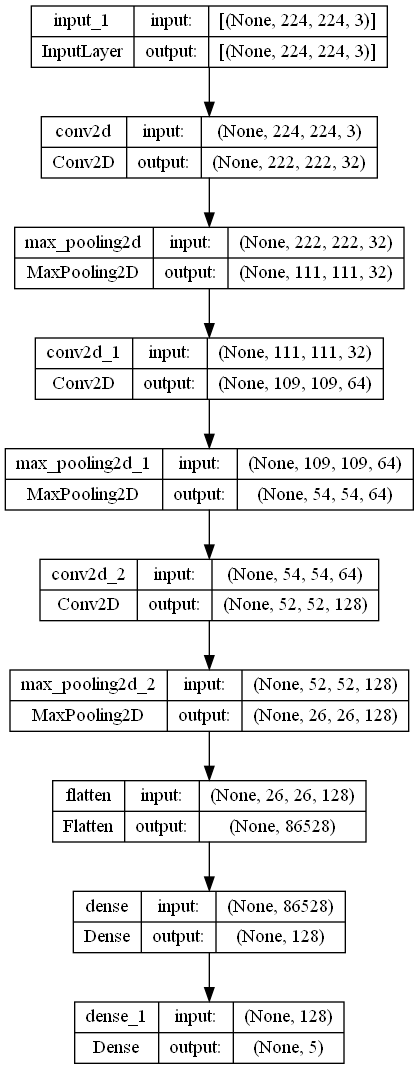

In [13]:
# Define the combined model
model = Model(inputs=input_cnn, outputs=output)
model.summary()

plot_model(model, to_file='model.png', show_shapes=True)

In [15]:
# Finally, we can compile the model to get it ready for trainning:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/20
4/4 [==============================] - 19s 5s/step - loss: 9824.5771 - accuracy: 0.0000e+00 - val_loss: 9534.8545 - val_accuracy: 0.0000e+00
Epoch 2/20
4/4 [==============================] - 18s 5s/step - loss: 8377.6826 - accuracy: 0.0000e+00 - val_loss: 9320.7461 - val_accuracy: 0.0000e+00
Epoch 3/20
4/4 [==============================] - 19s 5s/step - loss: 8714.6006 - accuracy: 0.0000e+00 - val_loss: 6308.4727 - val_accuracy: 0.0000e+00
Epoch 4/20
4/4 [==============================] - 19s 5s/step - loss: 6178.7539 - accuracy: 0.7500 - val_loss: 6113.7915 - val_accuracy: 0.0000e+00
Epoch 5/20
4/4 [==============================] - 23s 6s/step - loss: 6323.7168 - accuracy: 0.0000e+00 - val_loss: 10562.3408 - val_accuracy: 0.0000e+00
Epoch 6/20
4/4 [==============================] - 18s 5s/step - loss: 9675.6719 - accuracy: 0.0000e+00 - val_loss: 5550.6968 - val_accuracy: 0.0000e+00
Epoch 7/20
4/4 [==============================] - 20s 5s/step - loss: 7409.0088 - accuracy:

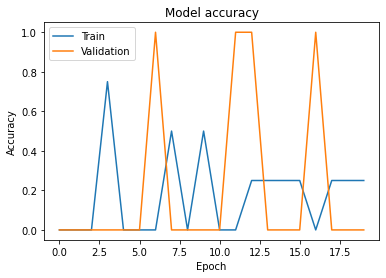

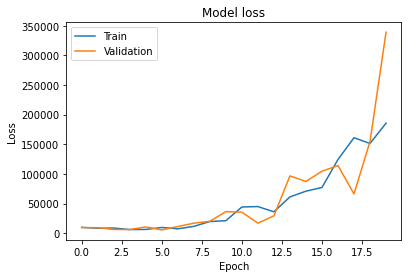

In [19]:

# Train the model
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
# Evaluate the model on the test data and output the confusion matrix
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

# test_predictions = model.predict(test_generator)
# test_predicted_classes = np.argmax(test_predictions, axis=1)

# test_true_classes = test_generator.classes
# class_labels = list(test_generator.class_indices.keys())

# confusion_matrix = tf.math.confusion_matrix(
#     test_true_classes, test_predicted_classes, num_classes=len(class_labels))

# print("Confusion matrix:")
# print(confusion_matrix.numpy())

1/1 [==============================] - 2s 2s/step - loss: 338913.3438 - accuracy: 0.0000e+00
Test loss: 338913.34375
Test accuracy: 0.0
